## Example of CNN architecture in PyTorch
Code slightly modified from: https://pytorch.org/tutorials/beginner/nn_tutorial.html

Some Theoretical Background:
https://cs231n.github.io/convolutional-networks/  
PyTorch Conv2D documentation-
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d  
-See class implementation in classicalCNN.py  

Pre-trained models exist for the original model hyperparameters in the 'model' folder

In [2]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor

#Will download MNIST dataset to a new 'data' folder; which is ignored in the gitignore
training_data = datasets.MNIST(
    root='data',
    train = True,
    transform=ToTensor(),
    download=True
)

testing_data = datasets.MNIST(
    root='data',
    train = False,
    transform = ToTensor()
)

print(training_data.data.size())
print(training_data.targets.size())
print(testing_data.data.size())
print(testing_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


Orig Shape: torch.Size([1, 28, 28]) Squeezed Shape: torch.Size([28, 28])


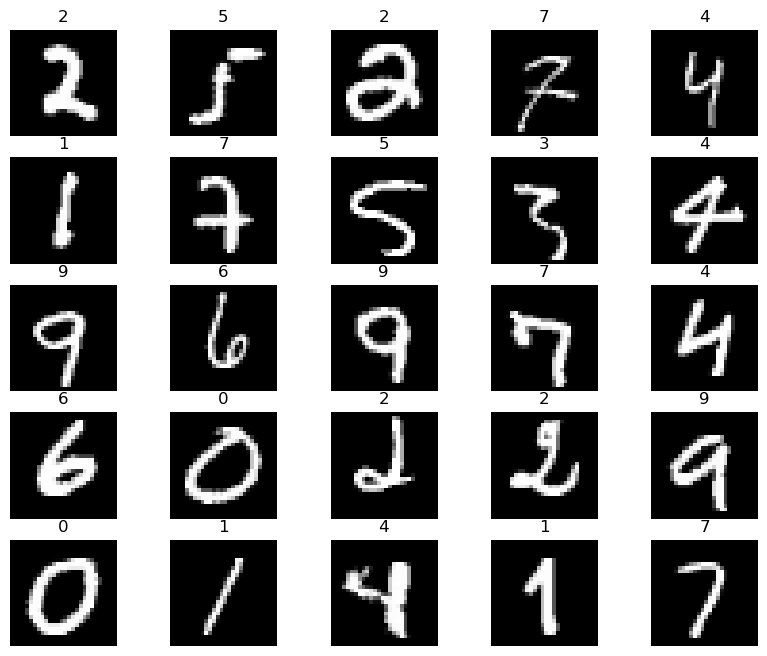

In [3]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() #Generate a random element in a 1x1 tensor, and get its value
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.axis("off")
    if i==0: #Demonstrate tensor shapes
        print("Orig Shape:", img.shape, "Squeezed Shape:", img.squeeze().shape)
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [4]:
from torch import optim
from classicalCNN import mnistCNN

model = mnistCNN()
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)



cuda


In [5]:
#Use the GPU if possible
model.to(device)

from torch.utils.data import DataLoader

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    def __len__(self):
        return len(self.dl)
    def __iter__(self):
        batches = iter(self.dl)
        for batch in batches:
            yield (self.func(*batch))

#device defined in previous module
def toGPU(x, y):
    return x.to(device), y.to(device)

train_loader = WrappedDataLoader(DataLoader(
    training_data, batch_size=100, shuffle=True, num_workers=1
), toGPU)

test_loader = WrappedDataLoader(DataLoader(
    testing_data, batch_size=100, shuffle=True, num_workers=1
), toGPU)

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

def train(model, loader, loss_function, optimizer, num_epochs=10, save_path='model'):
    model.train()

    total_step = len(loader)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, (images, label) in enumerate(loader):
            output = model(images)

            loss = loss_function(output, label)

            optimizer.zero_grad() #Reset Gradients
            loss.backward() #Calculate backpropagation gradients

            optimizer.step() #Perform parameter update step

            total_loss += loss.item()

            if (i+1) % 100 == 0:
                print('Epoch {}/{}, Step {}/{}, Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        writer.add_scalar("Loss/train", total_loss, epoch)

        checkpoint = {
            'model': model.state_dict(),
            'loss': loss
        }
        torch.save(checkpoint, save_path + '/epoch_' + str(epoch+1) + '.pt')
            
def test(model, loader):
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze() 
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print("Prediction Accuracy:", accuracy)


In [8]:
train(model, train_loader, loss_func, optimizer)

Epoch 1/10, Step 100/600, Loss: 0.2629
Epoch 1/10, Step 200/600, Loss: 0.1707
Epoch 1/10, Step 300/600, Loss: 0.1364
Epoch 1/10, Step 400/600, Loss: 0.1767
Epoch 1/10, Step 500/600, Loss: 0.0773
Epoch 1/10, Step 600/600, Loss: 0.0417
Epoch 2/10, Step 100/600, Loss: 0.1470
Epoch 2/10, Step 200/600, Loss: 0.0202
Epoch 2/10, Step 300/600, Loss: 0.0155
Epoch 2/10, Step 400/600, Loss: 0.0192
Epoch 2/10, Step 500/600, Loss: 0.0544
Epoch 2/10, Step 600/600, Loss: 0.0259
Epoch 3/10, Step 100/600, Loss: 0.0333
Epoch 3/10, Step 200/600, Loss: 0.0199
Epoch 3/10, Step 300/600, Loss: 0.0309
Epoch 3/10, Step 400/600, Loss: 0.0254
Epoch 3/10, Step 500/600, Loss: 0.1042
Epoch 3/10, Step 600/600, Loss: 0.0080
Epoch 4/10, Step 100/600, Loss: 0.0431
Epoch 4/10, Step 200/600, Loss: 0.0060
Epoch 4/10, Step 300/600, Loss: 0.0302
Epoch 4/10, Step 400/600, Loss: 0.0589
Epoch 4/10, Step 500/600, Loss: 0.0185
Epoch 4/10, Step 600/600, Loss: 0.0242
Epoch 5/10, Step 100/600, Loss: 0.0327
Epoch 5/10, Step 200/600,

In [9]:
eval_model = mnistCNN()
load = torch.load('./model/epoch_10.pt')
eval_model.load_state_dict(load['model'])
eval_model.to(device)

test(eval_model, test_loader)

Prediction Accuracy: 1.0


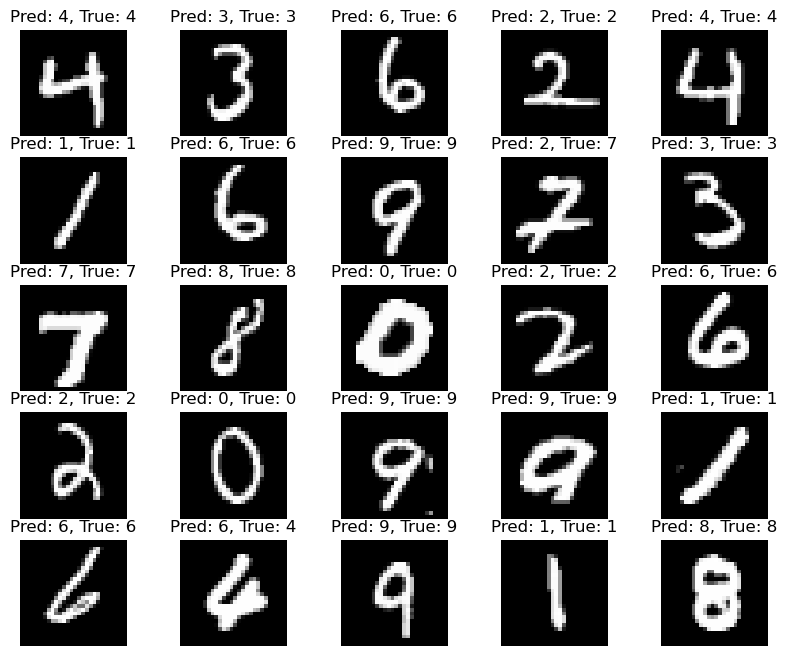

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    sample_idx = torch.randint(len(testing_data), size=(1,)).item() #Generate a random element in a 1x1 tensor, and get its value
    img, label = testing_data[sample_idx]
    test_output = model(torch.unsqueeze(img, 0).to(device)) #Model params trained with 4D input
    pred_y = torch.max(test_output, 1)[1].data.squeeze() 
    figure.add_subplot(rows, cols, i+1)
    plt.title("Pred: {}, True: {}".format(pred_y, label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

Edit im_test.png and run the following code to see the CNN prediction in action

In [11]:
import numpy as np
from PIL import Image

img = Image.open("im_test.png")
img = img.convert("L")

im_arr = torch.as_tensor(np.array(img))
im_arr = torch.reshape(im_arr, (1, 1, 28, 28))
im_arr = im_arr.type(torch.float32)

test_output = model(im_arr.to(device)).detach()
y_preds = test_output[0]
pred_y = torch.max(y_preds, dim=0)[1]
print("Predicted Value:", pred_y.item())

m = torch.nn.Softmax(0)
y_preds = m(y_preds)
print("Probabilities:", y_preds)


Predicted Value: 3
Probabilities: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
